# Training the Smile CNN

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from classifiers.lenet5 import LeNet5

In [ ]:
# path to input dataset of faces
dataset = './datasets/SMILEs'
# path to output model
model_path = './output/model_persistence/smile-lenet.hdf5'

In [ ]:
imagePaths = glob.glob('./datasets/SMILEs/**/**/*.jpg')

In [ ]:
from utils.image_preprocessor import AspectAwarePreprocessor
from utils.image_preprocessor import ImagePreprocessor
from utils.image_preprocessor import ImageToArrayPreprocessor

aap = AspectAwarePreprocessor(28, 28)
iap = ImageToArrayPreprocessor()

In [ ]:
# initialize the list of data and labels
data = []
labels = []
# loop over the input images
for imagePath in sorted(imagePaths):
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = aap.preprocess(image)
    image = iap.preprocess(image)
    data.append(image)
    
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)
    
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
from classifiers.lenet5 import LeNet5

# initialize the model
print("[INFO] compiling model...")
model = LeNet5().build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

In [24]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=le.classes_))

# save the model to disk
print("[INFO] serializing network...")
model.save(model_path)

[INFO] evaluating network...
              precision    recall  f1-score   support

 not_smiling       0.93      0.93      0.93      1895
     smiling       0.82      0.83      0.83       738

    accuracy                           0.90      2633
   macro avg       0.88      0.88      0.88      2633
weighted avg       0.90      0.90      0.90      2633

[INFO] serializing network...


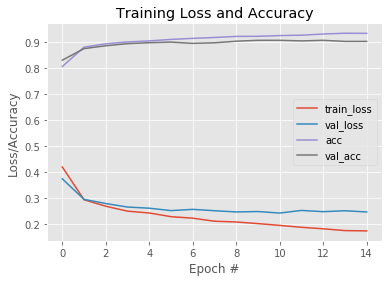

In [25]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Running the Smile CNN in Real-time

In [ ]:
# import the necessary packages
from keras.models import load_model
import numpy as np
import cv2

In [ ]:
# path to where the face cascade resides
cascade = './datasets/SMILEs/haarcascade_frontalface_default.xml'
# path to pre-trained smile detector CNN
model_path = './output/model_persistence/smile-lenet.hdf5'
# path to the video file
video = './datasets/SMILEs/smile.mp4'

In [ ]:
# load the face detector cascade and smile detector CNN
detector = cv2.CascadeClassifier(cascade)
model = load_model(model_path)

# if a video path was not supplied, grab the reference to the webcam
# camera = cv2.VideoCapture(0)
# otherwise, load the video
camera = cv2.VideoCapture(video)

aap = AspectAwarePreprocessor(300, 300)

In [ ]:
# keep looping
while True:
    # grab the current frame
    (grabbed, frame) = camera.read()

    # if we are viewing a video and we did not grab a frame, then we
    # have reached the end of the video
    if not grabbed:
        break

    # resize the frame, convert it to grayscale, and then clone the
    # original frame so we can draw on it later in the program
    frame = aap.preprocess(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameClone = frame.copy()

    # detect faces in the input frame, then clone the frame so that
    # we can draw on it
    rects = detector.detectMultiScale(gray, scaleFactor=1.1, 
                                      minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    
    # loop over the face bounding boxes
    for (fX, fY, fW, fH) in rects:
        # extract the ROI of the face from the grayscale image,
        # resize it to a fixed 28x28 pixels, and then prepare the
        # ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (28, 28))
        roi = roi.astype("float") / 255.0
        roi = iap.preprocess(roi)
        roi = np.expand_dims(roi, axis=0)
        
        # determine the probabilities of both "smiling" and "not
        # smiling", then set the label accordingly
        (notSmiling, smiling) = model.predict(roi)[0]
        label = "Smiling" if smiling > notSmiling else "Not Smiling"
        
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frameClone, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)
        
    # show our detected faces along with smiling/not smiling labels
    cv2.imshow("Face", frameClone)
    
    # if the ’q’ key is pressed, stop the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

Well Done